In [4]:
import kwant
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.sparse.linalg as sla
import numpy as np
import tinyarray
import matplotlib.cm as cm
import shelve
import textmyself as tm
from datetime import datetime as dt

ImportError: No module named 'kwant'

In [26]:
# Pauli matrices
s0 = tinyarray.array([[1, 0], [0, 1]])
sx = tinyarray.array([[0, 1], [1, 0]])
sy = tinyarray.array([[0, -1j], [1j, 0]])
sz = tinyarray.array([[1, 0], [0, -1]])

In [27]:
class SimpleNamespace(object):
    """A simple container for parameters."""
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

In [28]:
#p = SimpleNamespace(d=1.0, t=1.0, dis=0, salt='', mu=1.9, \
                    #stripe_l=1.0, nrwires=13, gapratio=0.9)
"""
 Parameters:
    -----------
    a : natural. 
        Lattice constant
    W : natural. 
        Width of system in lattic points
    L : natural. 
        Lenth of system in lattic points
    mu : real. 
        Chemical potential
    delta : real. 
        Superconducting gap
    Vx: real.
        Potential in x dir
    Phase: real.
        Phase of something???
"""
p = SimpleNamespace(a = 1, W = 20, L = 20, mu = 1.0, delta = 1.0, attach_leads = True, Vx = 0., phase = 0)

In [29]:
def onsite_e(p):
    """Onsite Hamiltonian element for electrons"""
    return ((1/p.a**2 - p.mu) * s0 + p.Vx * sx)

def onsite_h(p):
    """Onsite Hamiltonian element for holes"""
    return (- (1/p.a**2 - p.mu) * s0 + p.Vx * sx)

def hop_horz(p):
    """"Horizontal hopping Hamiltonian element"""
    return ((1j * sy)/(2*p.a) - s0/(2 * p.a**2))

def hop_vert(p):
    """"Vertical hopping Hamiltonian element"""
    return (-1j * sx/(2 * p.a) - s0/(2 * p.a**2))

def theta(x):
    """"Theta function: returns 1 for x >=0, and 0 for x < 0"""
    if x >=1:
        return (1)
    else:
        return (0)
    
def supercond(p, i):
    left_supercond = p.delta * theta(p.a* i - p.L) * s0
    right_supercond = p.delta *  theta(-p.a * i + p.L) * (np.cos(p.phase) - 1j * np.sin(p.phase)) * s0
    return(left_supercond + right_supercond)    

In [30]:
def make_modes_func(t, N_orb, W):
    """Construct lead modes.

    Parameters:
    -----------
    t : real.
        Hopping amplitude in the lead.
    N_orb : integer.
        Number of orbitals per site.
    W : integer.
        Number of sites connected to the lead.
    """
    momenta = np.array([ np.sign(t) * np.pi / 2] * N_orb * W +
                       [-np.sign(t) * np.pi / 2] * N_orb * W)
    velocities = np.array([-2 * np.abs(t)] * N_orb * W +
                          [ 2 * np.abs(t)] * N_orb * W)
    wave_functions = np.array(np.bmat(
        [[ 1/np.sqrt(np.abs(2 * t)) * np.eye(N_orb * W),
           1/np.sqrt(np.abs(2 * t)) * np.eye(N_orb * W)]]))
    prop_modes = kwant.physics.PropagatingModes(wave_functions,
                                                velocities, momenta)

    nmodes = N_orb * W
    vecs = wave_functions
    vecslmbdainv = t * np.dot(vecs,
        np.diag([-1j * np.sign(t)] * N_orb * W +
                [ 1j * np.sign(t)] * N_orb * W))
    stab_modes = kwant.physics.StabilizedModes(vecs, vecslmbdainv, nmodes)

    def modes_func(energy, args=[]):
        return (prop_modes, stab_modes)

    return modes_func

In [31]:
def rectangular_grid_hopping(L, W):
    """Produce a list of coordinates and hoppings for a rectangular grid of 
    width W and length L
    Parameters:
    -----------
    L: Natural.
        Length of grid.
    W: Natural.
        Width of grid.
    Returns:
    --------
    coords: list.
        List of discretized coordinates for our system.
    hoppings: list.
        List of possible hoppings from start coord to end coord"""
    
    coords = []
    vert_hoppings = []
    horz_hoppings = []
    
    for i in range(L):
        for j in range(W):
            coords.append([i, j])
            if i > 0:
                horz_hoppings.append([[i - 1, j], [i, j]])
            if j > 0:
                vert_hoppings.append([[i, j - 1], [i, j]])
                            
    return(coords, vert_hoppings, horz_hoppings)

In [32]:
def create_sys(leads=[]):
    """Construct a tight-binding model of a Josephson Junction.

    Parameters:
    -----------
     leads : list.
        List describing where and how many leads are attached to the system.
        Can be empty or contain 'l', 'r', 't', 'b', corresponding to left,
        right, top, and bottom leads, respectively.
        
    Returns:
    --------
    sys : <kwant.builder.FiniteSystem> object.
        Finalized system.
    """
    # gets list of coordinates on lattice and hopping coordinates as integers,
    # e.g. coords[0] = [0.0, 0.0], hoppings[0] = [[0.0, 0.0], [0.05, 0.05]]
    coords, vert_hoppings, horz_hoppings = rectangular_grid_hopping(p.L, p.W) # assumes lattice constant is 1, i.e. a == 1
    
    # this class allows us to turn our integer coordinates into the format
    # kwant requires
    class Lattice(kwant.builder.SiteFamily):
        def __init__(self, coords, name='lattice'):
            self.coords = coords
            super(Lattice, self).__init__(name, "")

        def normalize_tag(self, tag):
            try:
                tag = int(tag[0])
            except:
                raise KeyError

            if 0 <= tag < len(coords):
                return tag
            else:
                raise KeyError

        def pos(self, tag):
            return self.coords[tag]
        
    lat_e = Lattice(coords, name='e') # here we turns our coords into kwants coords format
    lat_h = Lattice(coords, name='h')
    sys = kwant.Builder() # initialize system
    
    for i in range(len(coords)):
        # sets onsite energies for electrons and holes
        sys[lat_e(i)] = onsite_e(p) 
        sys[lat_h(i)] = onsite_h(p) 
        sys[lat_e(i), lat_h(i)] = supercond(p, i)

    for i in range(len(horz_hoppings)):
        # sets horizontal hopping energies for electrons and holes
        sys[lat_e(coords.index(horz_hoppings[i][0])),
            lat_e(coords.index(horz_hoppings[i][1]))] =   hop_horz(p)
        sys[lat_h(coords.index(horz_hoppings[i][0])),
            lat_h(coords.index(horz_hoppings[i][1]))] = - hop_horz(p)
        
    for i in range(len(vert_hoppings)):
        # sets vertical hopping energies for electrons and holes
        sys[lat_e(coords.index(vert_hoppings[i][0])),
            lat_e(coords.index(vert_hoppings[i][1]))] =   hop_vert(p)
        sys[lat_h(coords.index(vert_hoppings[i][0])),
            lat_h(coords.index(vert_hoppings[i][1]))] = - hop_vert(p)

    left_sites = []
    right_sites = []
    top_sites = []
    bot_sites = []
    
    # finds the coordinates that are left/right/top/bottom sites
    for ind, c in enumerate(coords):
        # !!! check the 0 and p.L/p.W - 1 
        if c[0] == 0:
            left_sites.append(ind)
        if c[0] == p.L - 1:
            right_sites.append(ind)


    if 'l' in leads:
        sites_left = [lat_e(i) for i in left_sites]
        modes_func_left = make_modes_func(1, 2, len(left_sites))
        lead_left = kwant.builder.ModesLead(modes_func_left, sites_left)
        sys.leads.append(lead_left)
        
        sites_left = [lat_h(i) for i in left_sites]
        modes_func_left = make_modes_func(1, 2, len(left_sites))
        lead_left = kwant.builder.ModesLead(modes_func_left, sites_left)
        sys.leads.append(lead_left)

    if 'r' in leads:
        sites_right = [lat_e(i) for i in right_sites]
        modes_func_right = make_modes_func(1, 2, len(right_sites))
        lead_right = kwant.builder.ModesLead(modes_func_right, sites_right)
        sys.leads.append(lead_right)
        
        sites_right = [lat_h(i) for i in right_sites]
        modes_func_right = make_modes_func(1, 2, len(right_sites))
        lead_right = kwant.builder.ModesLead(modes_func_right, sites_right)
        sys.leads.append(lead_right)

    return sys.finalized()

In [35]:

# def create_sys():
#     """Construct a tight-binding model of a Josephson Junction.

#     Parameters:
#     -----------
#      p: dict. 
#         Dictionary of args
        
#     Returns:
#     --------
#     sys : <kwant.builder.FiniteSystem> object.
#         Finalized system.
#     lat_e = kwant.lattice.square(p.a, name = 'e') #def e lat
#     lat_h = kwant.lattice.square(p.a, name = 'h') #def h lat
#     sys = kwant.Builder() 
#     for i in range(p.L): #itter horiz over sys(0 to L-1)a
#         for j in range(p.W): #itter vert over sys (0 to W-1)
#             sys[lat_e(i, j)] = on_site_e(p)
#             sys[lat_h(i, j)] = on_site_h(p)
#             sys[(lat_e(i, j), lat_h(i, j))] = supercond(p, i)
#             if i > 0:
#                 sys[(lat_e(i-1, j), lat_e(i, j))] =   hop_horz(p)
#                 sys[(lat_h(i-1, j), lat_h(i, j))] = - hop_horz(p)
#             if j > 0:
#                 sys[(lat_e(i, j-1), lat_e(i, j))] =   hop_vert(p)
#                 sys[(lat_h(i, j-1), lat_h(i, j))] = - hop_vert(p)
# #Attach leads
#     sym_left_lead  = kwant.TranslationalSymmetry((-p.a, 0))
#     sym_right_lead = kwant.TranslationalSymmetry(( p.a, 0))
#     left_lead  = kwant.Builder(sym_left_lead)
#     right_lead = kwant.Builder(sym_right_lead)
    
#     for j in range(p.W):
#         left_lead[lat_e(0, j)] = on_site_e(p)
#         right_lead[lat_e(0, j)] = on_site_e(p)
#         left_lead[ lat_h(0, j)] = on_site_h(p)
#         right_lead[lat_h(0, j)] = on_site_h(p)
#         if j > 0:
#             left_lead[ lat_e(0, j - 1), lat_e(0, j)] = hop_vert(p)
#             right_lead[lat_e(0, j - 1), lat_e(0, j)] = hop_vert(p)
#             left_lead[ lat_h(0, j - 1), lat_h(0, j)] = - hop_vert(p)
#             right_lead[lat_h(0, j - 1), lat_h(0, j)] = - hop_vert(p)
#         left_lead[ lat_e(0, j), lat_e(1, j)] = hop_horz(p)        
#         right_lead[lat_e(0, j), lat_e(1, j)] = hop_horz(p)
#         left_lead[ lat_h(0, j), lat_h(1, j)] = - hop_horz(p)        
#         right_lead[lat_h(0, j), lat_h(1, j)] = - hop_horz(p)
        
#     if p.attach_leads:  
#         sys.attach_lead(left_lead)
#         sys.attach_lead(right_lead)
# #Pass the finalized system to a solver
#     sys = sys.finalized()
#     return sys    

In [36]:
#kwant.plot(create_sys())

In [37]:
def plot_conductance(sys, energies):
    # Compute conductance
    data = []
    for energy in energies:
        smatrix = kwant.smatrix(sys, energy)
        data.append(smatrix.transmission(2, 0) + smatrix.transmission(1, 3))

    plt.figure()
    plt.plot(energies, data)
    plt.xlabel("energy [t]")
    plt.ylabel("conductance [e^2/h]")
    plt.show()
    

In [38]:
# p.delta = 0.01
# sys = create_sys()
# energies = np.linspace(-0.5, 0.5, 100)
# plot_conductance(sys, energies)

In [39]:
# p.W=10
# p.delta=0.01
# sys = create_sys(['r', 'l'])

# energies = np.linspace(-0.5, 0.5, 100)
# plot_conductance(sys, energies)

In [40]:
def get_detr(sys, energy):
    """Compute the determinant of the reflection block.

    Parameters:
    -----------
    sys : <kwant.builder.FiniteSystem> object.
        Finalized system, as returned by create_sys().

    Returns:
    --------
    detr : real.
        Determinant of the reflection block, assuming only two leads
        are attached.
    """
    smatrix = kwant.smatrix(sys, energy = energy)
    n, m = smatrix.data.shape
    rblock = np.asmatrix(smatrix.data[:n//2, :m//2])
    detr = np.linalg.det(rblock)
    return detr.real

In [41]:
def evaluate_C0(murange, deltarange, potentialrange):
    list_c0   = []
    list_detr = []
    for mu in murange:
        for delta in deltarange:
            for potential in potentialrange:
                c0 = mu**2 + delta**2 - potential**2
                p.W = 1
                p.delta = delta
                p.Vx = potential
                p.mu = mu
                detr = get_detr(create_sys(["l", "r"]), energy = 0)
                list_c0.append(c0)
                list_detr.append(detr)
                
    plt.ylabel("Topological = 1, Trivial = 0")
    plt.xlabel("C0")
    plt.title("Topological vs C0", y = 1.04)
    plt.scatter(list_c0, list_detr)
    plt.show()
    
    

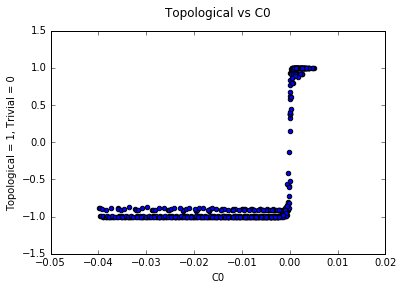

In [56]:
p.L=200
murange = np.linspace(0.0, 0.05, 5)
deltarange = np.linspace(0.01, 0.05, 5)
potentialrange = np.linspace(0., 0.2, 21)
evaluate_C0(murange, deltarange, potentialrange)

In [42]:
def phase_diagram_data(murange, potentialrange, name, W, delta):
    start = dt.now()
    phase_realisations = []
    p.W = W
    p.delta = delta
    for i, potential in enumerate(potentialrange):
        phase_realisations.append([])
        for j, mu in enumerate(murange):
            p.Vx = potential
            p.mu = mu
            detr = get_detr(create_sys(["l", "r"]), energy = 0)
            phase_realisations[i].append(detr)
#             if  0 <= detr <= 1 :                                                 
#                 phase_realisations[i].append(1)
#             else:
#                 phase_realisations[i].append(0)
    end = dt.now()
    howLong = (end - start).seconds / 60
    shelfFile = shelve.open('Phase Diagram Data')
    shelfFile[name] = (murange, potentialrange, phase_realisations)
    shelfFile.close()
#     tm.sendText("\nRan phase_diagram_data() for %s\nTime taken: %r min" % (name, howLong))
    
#     extent=[longitude_top_left,longitude_top_right,latitude_bottom_left,latitude_top_left]

In [49]:
def plot_phase_diagram(murange, potentialrange, phase_realisations):
    plt.ylabel("Vx")
    plt.xlabel("Mu")
    plt.title("Phase diagram of Josephson Junction", y = 1.04)
    plt.imshow(phase_realisations, extent = (murange.min(), murange.max(), potentialrange.max(), \
                                      potentialrange.min()),cmap = cm.binary)

In [50]:
murange = np.linspace(0.0, 1., 50)
potentialrange = np.linspace(0.0, 1., 50)

# # for i in range(2, 3):
# W = 2
# print(W)
# name = "Width of %s - Narrow View" % (str(W))
# phase_diagram_data(murange, potentialrange, name, W, 0.05)

# murange = np.linspace(0.0, 2., 50)
# potentialrange = np.linspace(0.0, 2., 50)
# name = '1'
# phase_diagram_data(murange, potentialrange, name, W, 0.05)

In [51]:
def normalize(data):
    minData = -1.0
    maxData =  1.0
    newData = []
    for i, d1 in enumerate(data):
        newData.append([])
        for d2 in d1:
            normalizedD2 = (d2 - minData)/(maxData - minData)
            newData[i].append(normalizedD2)
    return newData

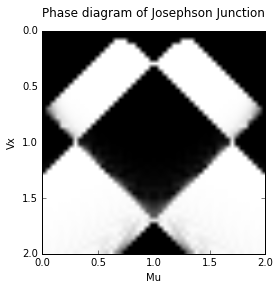

In [81]:
shelfFile = shelve.open('Phase Diagram Data')
data = shelfFile['Width of 2']
murange, potentialrange, phase_realisations = data
plot_phase_diagram(murange, potentialrange, phase_realisations)
shelfFile.close()
# Topological = Black
# Trivial = White

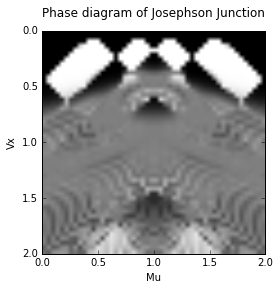

In [72]:
shelfFile = shelve.open('Phase Diagram Data')
data = shelfFile['Width of 4']
murange, potentialrange, phase_realisations = data
plot_phase_diagram(murange, potentialrange, phase_realisations)
shelfFile.close()
# Topological = Black
# Trivial = White

In [54]:
p.W = 4
p.L = 200
p.delta = 0.05
p.mu = 0.3
p.Vx = 0.54
print(2.0/0.54)

sys = create_sys(['r', 'l'])
get_detr(sys, 0)

3.7037037037037033


-0.48470405978336489

In [1]:
def plot_energies(trange, mu, delta, W, L):
    
    ev = sla.eigsh(create_sys(['r', 'l']), k=8, which='SM', return_eigenvectors=False, maxiter=100000) #which = what energy levels to return
                                                # SM = smallest absolute value, i.e. closest to 0, maxiter = ???, k = 8 ???

    energies = []
    
    for t in trange:
        
        energies.append(np.sort(energy(t,delta, mu, W, L)))

    plt.figure()
    plt.xlabel('Hopping potential')
    plt.ylabel('Energy')
    plt.title('How energy states vary with hopping potential in a quantum wire', y=1.02)
    plt.plot(trange, energies)
    plt.show()
    
"""
This function plots how the eigenvalues of the system change as we change the hoppoing potential
"""

'\nThis function plots how the eigenvalues of the system change as we change the hoppoing potential\n'

In [2]:
trange = np.linspace(0.1, 2.0, 10)
#plot_energies(trange, mu, delta, W, L)
plot_energies(trange, 1., 1.0, 2, 100)

NameError: name 'np' is not defined